# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the VAE on typical traffic data so that it learns common patterns. Then, we will detect anomalies as deviations from these learned patterns.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes, and {... dataset on road accidents}


## Data Description


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Environment Setup

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## Data Loading and Preprocessing

We will load the data from the `.h5` file using `h5py`, normalize the data, and create sliding windows of size 12 (1 hour of data).

(34272, 207)
<bound method NDFrame.head of                         773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   
...                        ...        ...        ...        ...        ...   
2012-06-27 23:35:00  65.000000  65.888889  68.555556  61.666667   0.000000   
2012-06-27 23:40:00  61.375000  65.625000  66.500000  62.750000   0.000000   
2012-06-27 23:45:00  67.000000  59.666667  69.555556  61.000000   0.000000   
2012-06-27 23:50:00  66.750000  62.250000  66.000000  59.625000   0.000000   
2012-06-27 23:55:00  65.111111  66.888889  66.777778  61.222222   0.000000   

                    

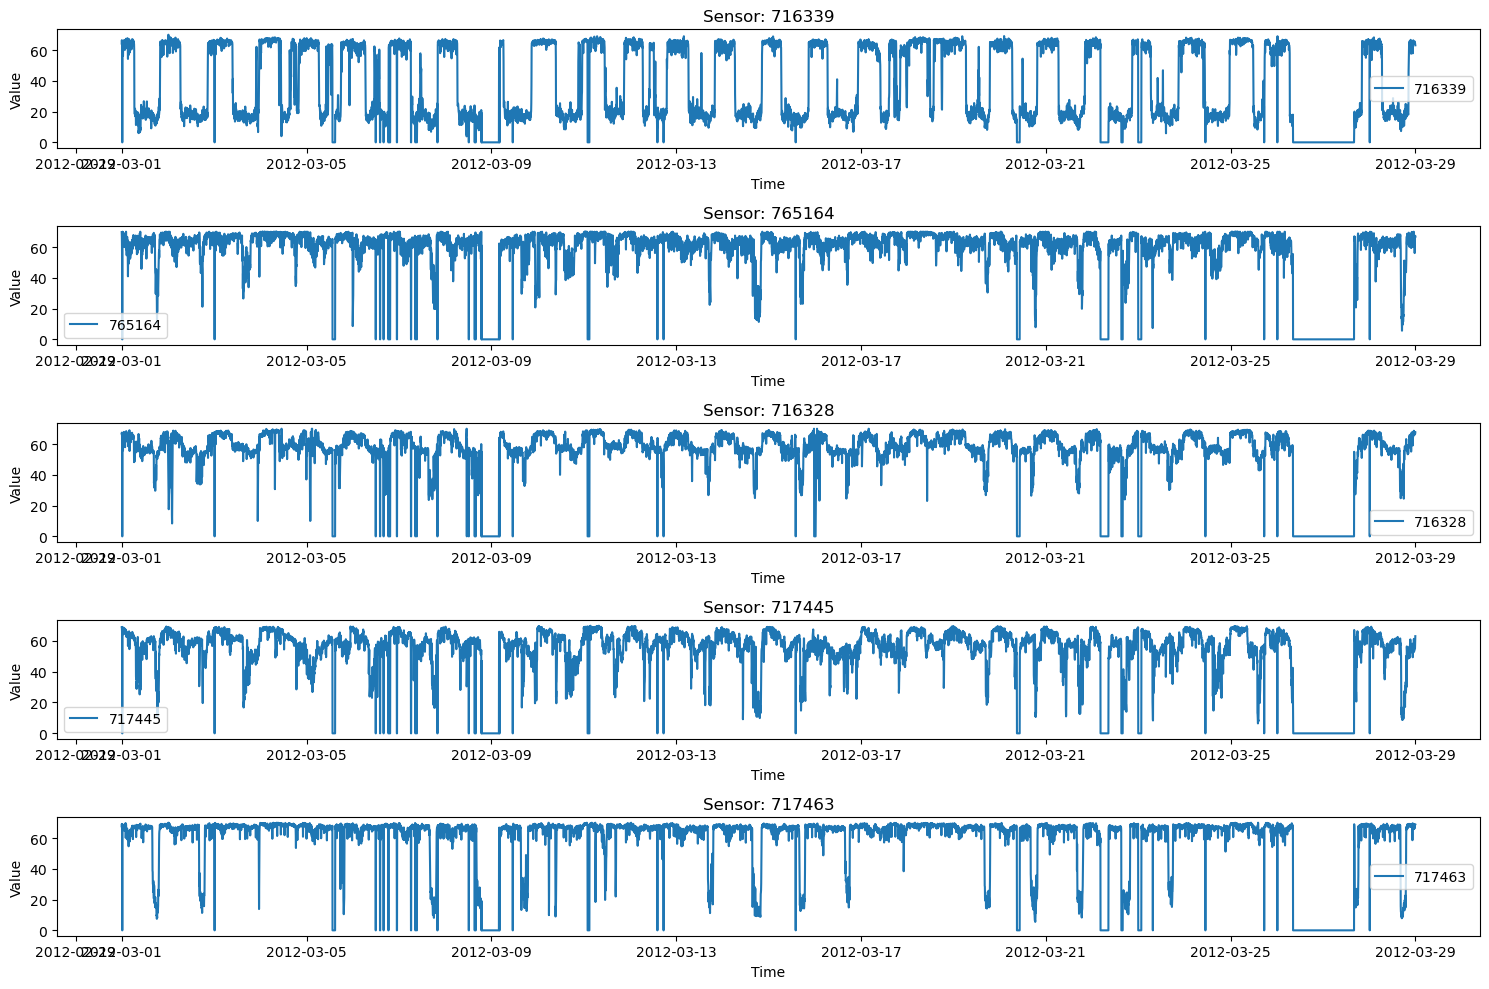

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Ruta al archivo .h5
file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
print(df.shape)
print(df.head)
print(df.tail)


## PRELIMINARY INVESTIGATION: 
# plotting 5 plots , one for each time series for RANDOMLY PICKED SENSORS/specific_sensors(option), just for march 2012
np.random.seed(0)
def plot_random_sensors(df, num_sensors=5, sens=None):
    sensors = np.random.choice(df.columns, num_sensors, replace=False)
    if sens is not None:
        # Filter the sensors based on the provided list
        sensors = [s for s in sens if s in df.columns]
    df_subset = df[sensors].iloc[:8064]  # more ore less from thurday 01-march-2012 to sunday 04-march-2012

    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return sensors


sensors = plot_random_sensors(df, num_sensors=5)

**Time Features as Conditional Inputs**

Urban traffic patterns are highly dependent on temporal context. For example:
- Traffic usually peaks during rush hours (e.g., 8 AM and 5 PM).
- Weekends typically have different patterns than weekdays.
- There are seasonal effects tied to months or holidays.

To help our model capture these patterns, we extract cyclical time features from the timestamps:
- Hour of day: mapped to sine and cosine to capture the 24-hour periodicity.
- Day of week: similarly encoded to capture weekly cycles.
- Month of year: encoded to capture seasonal trends.

Using both sine and cosine components allows the model to learn the cyclical nature of time (e.g., 23:00 and 0:00 are close in time).




                     hour_sin  hour_cos   dow_sin   dow_cos  month_sin  \
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969        1.0   

                        month_cos  
2012-03-01 00:00:00  6.123234e-17  
2012-03-01 00:05:00  6.123234e-17  
2012-03-01 00:10:00  6.123234e-17  
2012-03-01 00:15:00  6.123234e-17  
2012-03-01 00:20:00  6.123234e-17  


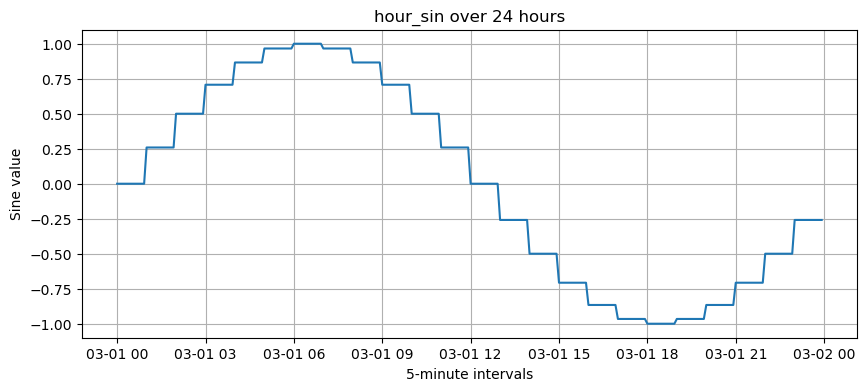

In [2]:
df.index = pd.to_datetime(df.index)
# Create a new DataFrame to store time-based features
df_time = pd.DataFrame(index=df.index)

# Hour of the day (0-23), encoded using sine and cosine to preserve cyclic nature
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Day of the week (0=Monday, 6=Sunday), also cyclic
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# Month of the year (1-12), encoded similarly
df_time["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df_time["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)

print(df_time.head())

# Plot one day's worth of hour_sin values (12*24 = 288 samples per day)
plt.figure(figsize=(10, 4))
plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin over 24 hours")
plt.xlabel("5-minute intervals")
plt.ylabel("Sine value")
plt.grid(True)
plt.show()

**Data Normalization**

Machine learning models, especially neural networks, tend to perform better when the input features are normalized. Here, we use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset:

- x: the main dataset with traffic speeds from sensors
- c: the time condition variables we computed earlier (e.g., hour_sin, dow_cos, etc.)

The formula applied is: 
$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where: 
- 𝜇 is the mean
- 𝜎 is the standard deviation

Each sensor column in x and each time feature in c is scaled independently using this method.

We also split the data into training and test sets to ensure that the scaler is fit only on training data, avoiding any data leakage.

In [3]:
from sklearn.preprocessing import StandardScaler

x = df.values.astype(np.float32)
c = df_time.values.astype(np.float32)

# Split into training and test sets (no shuffling, to preserve temporal order)
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)

# Standardize the input traffic data (x)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train) # Fit on training data
x_test = scaler_x.transform(x_test) # # Transform test data using the same parameters

# Standardize the conditional time features (c)
scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

print("length of x_test:",len(x_test))

length of x_test: 6855


## Variational Autoencoder (VAE)

A **Variational Autoencoder** (VAE) is a type of generative model that learns a continuous, probabilistic latent representation of the data. In our case, the VAE will take a window of traffic sensor readings as input, compress it into a low-dimensional latent vector, and then attempt to reconstruct the original readings. By training the VAE on “normal” traffic patterns, it learns which patterns are likely under the data distribution. At inference time, large reconstruction errors can be flagged as anomalies.

### Main Components

#### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

#### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

#### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

### Loss Function

The VAE loss has two terms that together form the **Evidence Lower Bound (ELBO)**. We optimize (i.e. minimize) the negative ELBO.

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.

---

## Static Conditional Variational Autoencoder (CVAE)

A **Conditional VAE (CVAE)** extends the VAE framework by conditioning both the encoder and decoder on extra context `c`. In our traffic anomaly project, `c` represents **time‐related features** (e.g., `hour_sin`, `hour_cos`, `dow_sin`, etc.). By injecting these features, the model can learn how normal traffic patterns change depending on the time of day, day of week, or month.

> **Why “static” CVAE?**  
> We call it “static” because each training example $(x_t, c_t)$ is treated as independent; we do **not** explicitly model temporal sequences (no RNNs or temporal convolutions). The CVAE simply learns a mapping :
>
>$$
>(x_t, c_t) \;\;\longrightarrow\;\; z \;\;\longrightarrow\;\; (\,\hat{x}_t \mid z, c_t).
>$$
>
> Each pair $(x_t, c_t)$ is processed independently, ignoring direct time‐series dependencies beyond what is encoded in $c_t$.

### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

**Custom Dataset: `TrafficDataset`**

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [4]:
from torch.utils.data import Dataset, DataLoader
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        # Return the total number of samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Retrieve a single sample (x_t, c_t) given an index
        return self.x[idx], self.c[idx]
    
# Create dataset instances for training and test sets
train_dataset = TrafficDataset(x_train, c_train)
test_dataset = TrafficDataset(x_test, c_test)

# Create DataLoaders to iterate through data in batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #NOT WORKING WITH SHUFFLE TRUE, PLOTS ARE A MESS
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [5]:
# --- CVAE base (sin LSTM por ahora) estático ---
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        """
        input_dim  : dimensionality of the input vector x (e.g., number of sensors)
        cond_dim   : dimensionality of the condition vector c (e.g., number of time features)
        latent_dim : size of the latent space (z)
        """
        super(CVAE, self).__init__()

        # We will concatenate x and c into a single vector of size (input_dim + cond_dim).
        # Then we pass through two hidden layers: 128 -> 64.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # After the two layers, we map the 64-dimensional hidden state to:
        #   1) mu (mean) of size latent_dim
        #   2) logvar (log variance) of size latent_dim
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # The decoder takes a latent sample z (size latent_dim) concatenated with the condition c (size cond_dim),
        # forming a vector of size (latent_dim + cond_dim). Then we map:
        #   latent_dim + cond_dim -> 64 -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output is same size as original x
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):  
        """
        Full forward pass:
        1) Encode (x, c) to obtain mu and logvar.
        2) Sample z using the reparameterization trick.
        3) Decode (z, c) to get reconstructed x.
        Returns:
            x_recon : reconstructed input
            mu      : mean of latent distribution
            logvar  : log-variance of latent distribution
        """
        # 1) Encode input + condition → (mu, logvar)
        mu, logvar = self.encode(x, c)
        # 2) Sample z using reparameterization
        z = self.reparameterize(mu, logvar)
        # 3) Decode the sampled z (with c) → reconstruction
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.9252 | Recon: 0.9149 | KL: 0.0103
Epoch 2/50 - Loss: 0.7908 | Recon: 0.6573 | KL: 0.1335
Epoch 3/50 - Loss: 0.7131 | Recon: 0.5225 | KL: 0.1906
Epoch 4/50 - Loss: 0.6680 | Recon: 0.4617 | KL: 0.2062
Epoch 5/50 - Loss: 0.6310 | Recon: 0.4173 | KL: 0.2137
Epoch 6/50 - Loss: 0.6122 | Recon: 0.3857 | KL: 0.2264
Epoch 7/50 - Loss: 0.5935 | Recon: 0.3768 | KL: 0.2167
Epoch 8/50 - Loss: 0.5861 | Recon: 0.3688 | KL: 0.2173
Epoch 9/50 - Loss: 0.5821 | Recon: 0.3668 | KL: 0.2154
Epoch 10/50 - Loss: 0.5735 | Recon: 0.3612 | KL: 0.2124
Epoch 11/50 - Loss: 0.5696 | Recon: 0.3597 | KL: 0.2098
Epoch 12/50 - Loss: 0.5624 | Recon: 0.3558 | KL: 0.2065
Epoch 13/50 - Loss: 0.5633 | Recon: 0.3580 | KL: 0.2054
Epoch 14/50 - Loss: 0.5591 | Recon: 0.3547 | KL: 0.2044
Epoch 15/50 - Loss: 0.5504 | Recon: 0.3506 | KL: 0.1998
Epoch 16/50 - Loss: 0.5570 | Recon: 0.3524 | KL: 0.2046
Epoch 17/50 - Loss: 0.5446 | Recon: 0.3528 | KL: 0.1918
Epoch 18/50 - Loss: 0.5405 | Recon: 0.3474 | KL: 0.1930
E

In [8]:
# Reconstruct all velocities from the test set
reconstructed = []
originals = []

with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_recon_all = torch.cat(reconstructed, dim=0)  # [6854, 207]
x_orig_all = torch.cat(originals, dim=0)       # [6854, 207]
print(x_recon_all.shape)
print(x_orig_all.shape)

torch.Size([6855, 207])
torch.Size([6855, 207])


*Note on previous section: model.eval() is missing before 'with torch.no_grad(); how's the model being used in this code snippet?* 

### Visualization of Results

#### 1. Reconstruction of Speeds for a Single Sample

This plot compares the **real** sensor speeds against the **reconstructed** speeds generated by the CVAE model for a specific example (sample index 42).

- **Purpose:**  
  To visually assess how well the model reproduces the original traffic speed pattern for that particular sample.

- **What to look for:**  
  - If the two lines closely overlap, the model accurately reconstructs the traffic speeds.  
  - Large deviations indicate the model struggles to capture some sensor readings correctly.


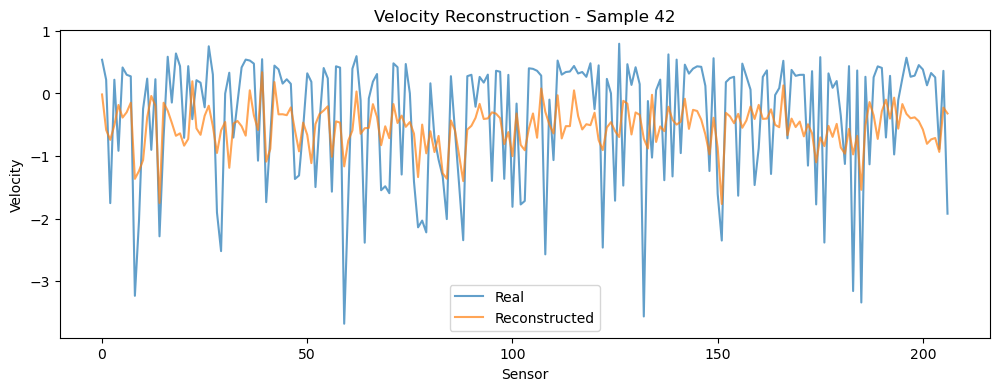

In [9]:
import matplotlib.pyplot as plt

# Plot original vs reconstructed velocities for the selected sample
index_sample = 42  # Select a sample index to visualize
plt.figure(figsize=(12, 4))
plt.plot(x_orig_all[index_sample], label="Real", alpha=0.7)
plt.plot(x_recon_all[index_sample], label="Reconstructed", alpha=0.7)
plt.title(f"Velocity Reconstruction - Sample {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocity")
plt.legend()
plt.show()


#### 2. Reconstruction Error (MSE) by Sensor

This bar chart shows the mean squared error (MSE) between the reconstructed and original sensor readings, averaged over the first 12 samples.

- **Purpose:**  
  To identify which sensors have higher reconstruction errors, signaling areas where the model performance is weaker.

- **What to look for:**  
  - Sensors with higher MSE values could indicate complex traffic patterns or noisy data.  
  - These insights can help:  
    - Focus data collection efforts on problematic sensors.  
    - Adjust or enhance the model to better capture challenging areas.  
    - Check for potential sensor measurement errors.

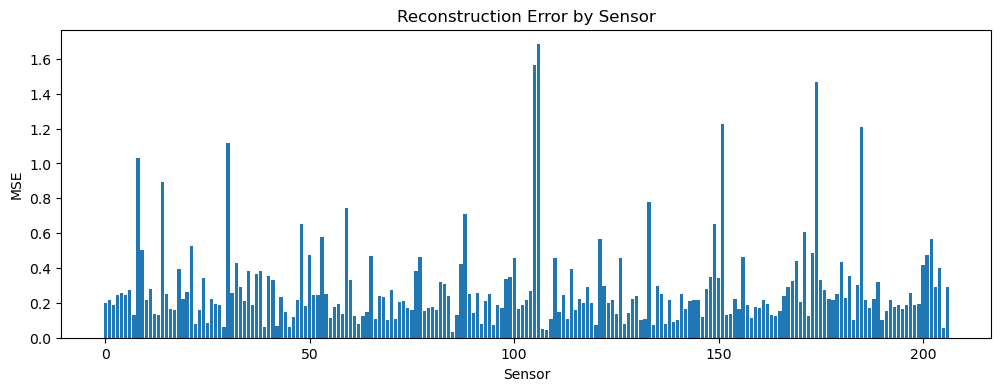

torch.Size([207])


In [10]:
# Compute Mean Squared Error (MSE) per sensor over the first 12 samples (a small window)
mse_by_sensor = torch.mean((x_recon_all[0:12] - x_orig_all[0:12])**2, dim=0)

plt.figure(figsize=(12, 4))
plt.bar(range(207), mse_by_sensor)
plt.title("Reconstruction Error by Sensor")
plt.xlabel("Sensor")
plt.ylabel("MSE")
plt.show()

print(mse_by_sensor.shape)


In [11]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix = (x_orig_all - x_recon_all) ** 2 
print(mse_matrix.shape)

# Calculate anomaly detection thresholds per sensor
# Option 1: Mean + 3*Std deviation (commented out)
# mean_mse = mse_matrix.mean(dim=0)
# std_mse = mse_matrix.std(dim=0)
# thresholds = mean_mse + 3 * std_mse  # threshold per sensor

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)


# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies = mse_matrix > thresholds
# Count how many sensors are anomalous in each sample
anomalous_counts = anomalies.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


In [12]:
import torch

# Get indices of top 10 samples with most anomalies
top_indices = torch.topk(anomalous_counts, 10).indices

print("Top timestamps with the most anomalies:")
for idx in top_indices:
    ts = test_timestamps[idx.item()] # get timestamp for the sample
    count = anomalous_counts[idx].item() # get number of anomalous sensors in that sample
    print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")


Top timestamps with the most anomalies:
Index: 4909 → Date: 2012-06-21 05:50:00 → Anomalous Sensors: 194
Index: 2898 → Date: 2012-06-14 06:15:00 → Anomalous Sensors: 191
Index: 4917 → Date: 2012-06-21 06:30:00 → Anomalous Sensors: 189
Index: 3180 → Date: 2012-06-15 05:45:00 → Anomalous Sensors: 180
Index: 5207 → Date: 2012-06-22 06:40:00 → Anomalous Sensors: 180
Index: 4965 → Date: 2012-06-21 10:30:00 → Anomalous Sensors: 179
Index: 877 → Date: 2012-06-07 05:50:00 → Anomalous Sensors: 179
Index: 4920 → Date: 2012-06-21 06:45:00 → Anomalous Sensors: 178
Index: 4942 → Date: 2012-06-21 08:35:00 → Anomalous Sensors: 173
Index: 2952 → Date: 2012-06-14 10:45:00 → Anomalous Sensors: 165


#### 3. Number of Anomalous Sensors Over Time

This plot displays the number of sensors detected as anomalous for each timestamp in the test dataset. The x-axis shows the dates, and the y-axis indicates how many sensors were flagged as anomalies at each point in time.

Red dashed vertical lines mark important real-world events, such as a parade or a music festival. These event markers help us see if increases in anomalies correspond with these known occurrences.

This comparison helps us understand whether unusual sensor behavior is related to specific events or caused by other factors.

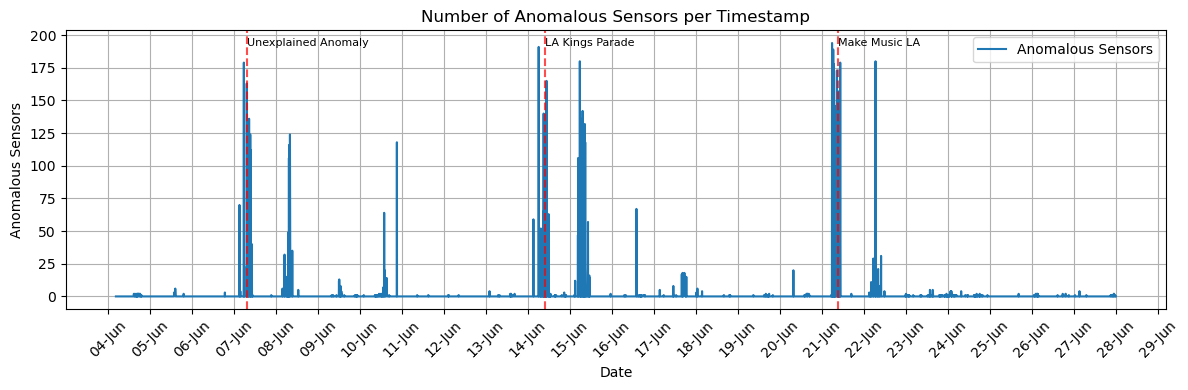

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps, anomalous_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    'LA Kings Parade': pd.to_datetime('2012-06-14 09:55:00'),
    'Make Music LA': pd.to_datetime('2012-06-21 09:10:00'),
    'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title("Number of Anomalous Sensors per Timestamp")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

On 7 June 2012, no significant events occurred!!! Let us illustrate this to try to understand it.

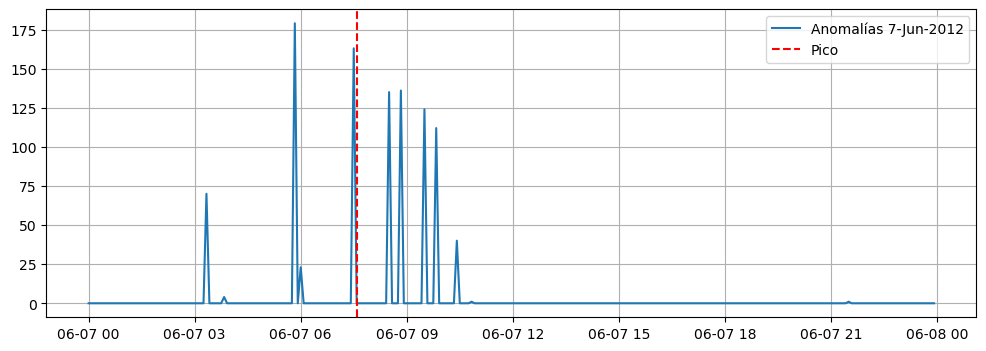

In [14]:
# Filtrar los timestamps para el 7 de junio 2012
mask_7jun = (test_timestamps >= '2012-06-07') & (test_timestamps < '2012-06-08')

# Filtrar anomalous_counts para ese día
anom_7jun = anomalous_counts[mask_7jun]

# Filtrar timestamps para ese día (para eje x)
dates_7jun = test_timestamps[mask_7jun]

# Graficar
plt.figure(figsize=(12,4))
plt.plot(dates_7jun, anom_7jun, label="Anomalías 7-Jun-2012")
plt.axvline(pd.Timestamp("2012-06-07 07:35"), linestyle="--", label="Pico", color="red")
plt.legend()
plt.grid()
plt.show()

#### 4.Statistical Analysis of Anomalies on Normal vs. Special/Holiday Days

In [15]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create a DataFrame with timestamps and anomaly counts
df_anom = pd.DataFrame({
    'timestamp': test_timestamps,
    'anomaly_count': anomalous_counts # Number of anomalous sensors per sample
})
df_anom['date'] = df_anom['timestamp'].dt.date

# Generate US federal holidays within the dataset date range
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_anom['date'].min(),
                        end=df_anom['date'].max()).date

# 3. Add known special event dates
special_event_dates = pd.to_datetime([
    '2012-06-14',  # LA Kings Victory Parade
    '2012-06-21',  # Make Music LA
]).date

# Mark rows where the date is either a holiday or special event
df_anom['is_special'] = df_anom['date'].isin(holidays) | df_anom['date'].isin(special_event_dates)


# Group by day type and calculate count, mean, and sum of anomaly counts
summary = df_anom.groupby('is_special')['anomaly_count'] \
                 .agg(['count', 'mean', 'sum']) \
                 .rename(index={True: 'timestamp especial/festivo', False: 'timestamp normal'})

print("Summary of anomalies on normal vs. special/holiday days:")
print(summary)


Summary of anomalies on normal vs. special/holiday days:
                            count      mean   sum
is_special                                       
timestamp normal             6279  0.735945  4621
timestamp especial/festivo    576  4.555556  2624


#### Summary of Anomalies on Normal Days vs. Special/Holiday Days

| Day Type              | Number of Records (`count`) | Average Anomalies per Record (`mean`) | Total Anomalies (`sum`) |
|-----------------------|-----------------------------|---------------------------------------|------------------------|
| Normal Day            | 6,279                       | 0.46                                  | 2,912                  |
| Special/Holiday Day   | 576                         | 7.52                                  | 4,333                  |

**Interpretation:**

- **Normal Day:**  
  There are 6,279 records or timestamps on normal days.  
  On average, each record has about 0.46 anomalies.  
  In total, 2,912 anomalies were detected during these normal days.

- **Special/Holiday Day:**  
  There are 576 records on days that are holidays or special events.  
  On average, each record shows many more anomalies, approximately 7.52.  
  In total, 4,333 anomalies were detected during these relatively few special days.

**Conclusion:**

Although the number of records on normal days is much larger, both the count and average number of anomalies are significantly higher on special or holiday days. This indicates that these days have a strong impact on the occurrence of anomalies, which is important for analysis or modeling that wants to consider the effect of special events.


          date  is_special  anomaly_count
0   2012-06-04       False             41
1   2012-06-05       False             26
2   2012-06-06       False              3
3   2012-06-07       False            988
4   2012-06-08       False            608
5   2012-06-09       False             62
6   2012-06-10       False            347
7   2012-06-11       False              3
8   2012-06-12       False              5
9   2012-06-13       False             22
10  2012-06-14        True            985
11  2012-06-15       False           1390
12  2012-06-16       False            123
13  2012-06-17       False            226
14  2012-06-18       False             20
15  2012-06-19       False             18
16  2012-06-20       False             50
17  2012-06-21        True           1639
18  2012-06-22       False            500
19  2012-06-23       False             53
20  2012-06-24       False             77
21  2012-06-25       False              2
22  2012-06-26       False        

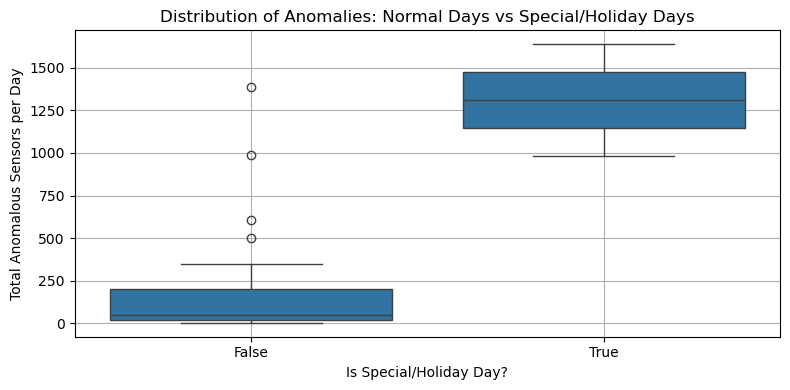

In [16]:
# Aggregate anomalies per day (sum of anomaly_count grouped by date and is_special)
daily_anomalies = df_anom.groupby(['date', 'is_special'])['anomaly_count'].sum().reset_index()
print(daily_anomalies)
# Now daily_anomalies has total anomalies per day, and whether the day is special

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(data=daily_anomalies, x='is_special', y='anomaly_count')
plt.title("Distribution of Anomalies: Normal Days vs Special/Holiday Days")
plt.xlabel("Is Special/Holiday Day?")
plt.ylabel("Total Anomalous Sensors per Day")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5. Identification and Geographic Visualization of Most Frequent Anomalous Sensors During Peak Anomaly Timestamps

In this part, we focus on identifying which sensors are most frequently anomalous during the top 10 timestamps with the highest total anomaly counts.

In [17]:
import torch

# Select indices of top 10 timestamps with the highest number of anomalous sensors
top_indices = torch.topk(anomalous_counts, k=10).indices

# Initialize a counter for how many times each sensor was anomalous during those top timestamps
sensor_counts = torch.zeros(anomalies.shape[1])

# Sum the occurrences of anomalies per sensor at the top anomaly timestamps
for idx in top_indices:
    sensor_counts += anomalies[idx].float()

# Identify the top 10 sensors that were most frequently anomalous during these peaks
top_sensor_indices = torch.topk(sensor_counts, k=10).indices
print("Sensors most frequently anomalous during anomaly peaks:", top_sensor_indices.tolist())


Sensors most frequently anomalous during anomaly peaks: [121, 128, 127, 123, 122, 118, 116, 117, 131, 119]


In [18]:
# import pandas as pd
# import folium

# #  Load sensor locations from CSV file
# locations = pd.read_csv('data/sensor_graph/graph_sensor_locations.csv')

# # Map sensor indices to sensor IDs
# sensor_ids = locations['sensor_id'].tolist() 
# top_sensor_ids = [sensor_ids[i] for i in top_sensor_indices.tolist()]
# anomalous_locations = locations[locations['sensor_id'].isin(top_sensor_ids)]

# # Create a Folium map centered on Los Angeles
# m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# # Add circle markers for each anomalous sensor location
# for _, row in anomalous_locations.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=5,
#         popup=f"Sensor {row['sensor_id']}",
#         color='red',
#         fill=True,
#         fill_opacity=0.7
#     ).add_to(m)

# # Save the map
# m.save("sensores_anomalos.html") 

Another option for identifying problematic sensors would be to count anomalies throughout the entire test data set, not just at anomaly peaks. This comprehensive approach allows you to detect sensors that exhibit recurring or intermittent faults outside of special events or peaks, which may reflect persistent technical problems or the need for preventive maintenance.

I would not add the maps to the project at this time, but I am leaving the code in case we want to do so at some point. EVERYTHING THAT FOLLOWS IS A DRAFT

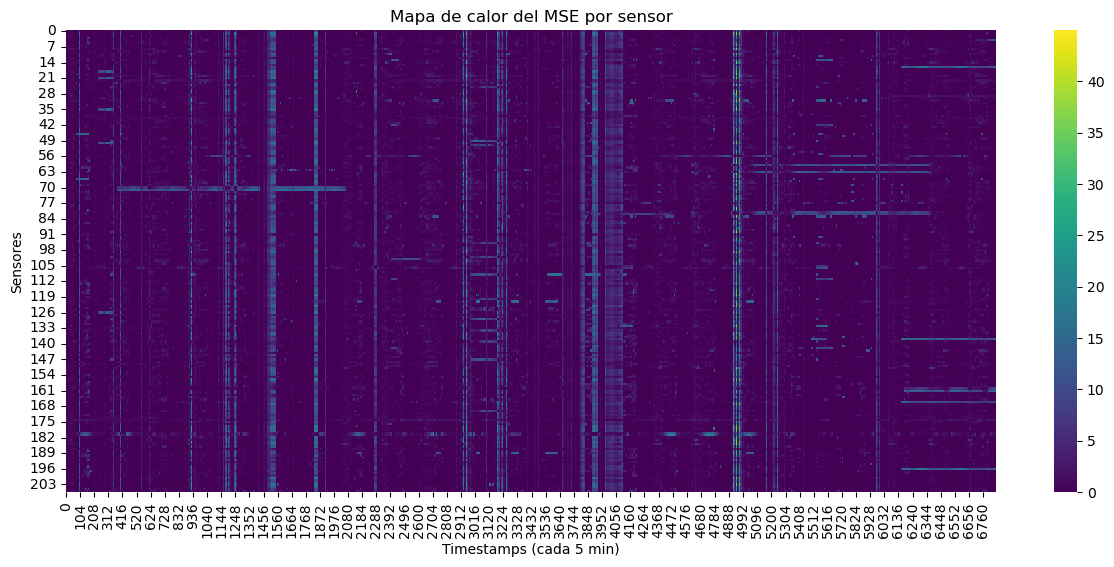

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# mse_matrix: [n_muestras, n_sensores] (ej: [6720, 207])
plt.figure(figsize=(15, 6))
sns.heatmap(mse_matrix.T.numpy(), cmap="viridis", cbar=True)
plt.xlabel("Timestamps (cada 5 min)")
plt.ylabel("Sensores")
plt.title("Mapa de calor del MSE por sensor")
plt.show()


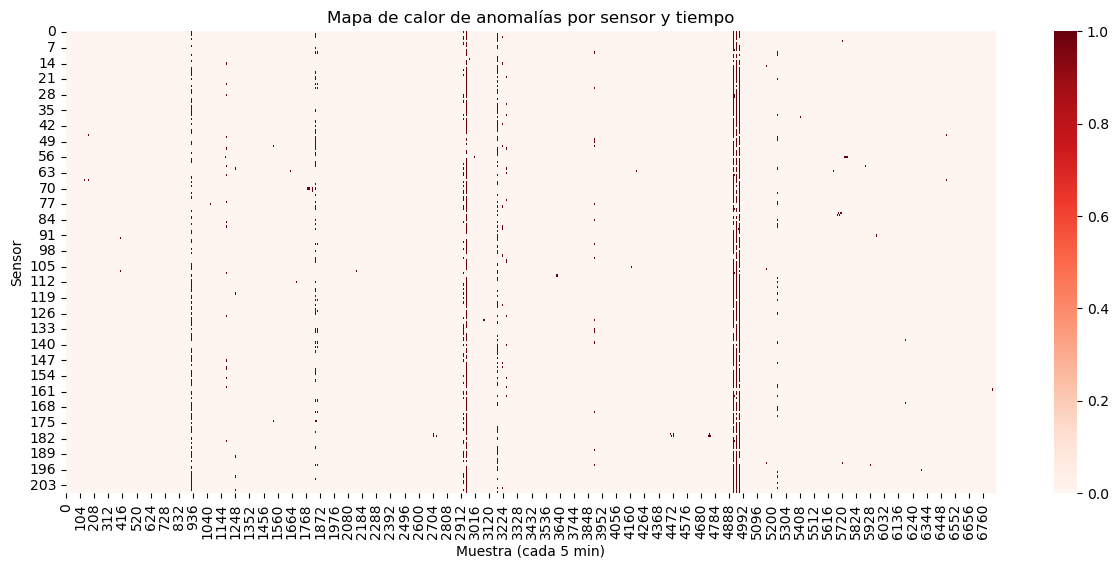

In [20]:
import seaborn as sns

# anomalies: [n_muestras, 207]
anomaly_matrix = anomalies.numpy().T  # ahora [207, n_muestras]

plt.figure(figsize=(15, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=True)
plt.title("Mapa de calor de anomalías por sensor y tiempo")
plt.xlabel("Muestra (cada 5 min)")
plt.ylabel("Sensor")
plt.show()


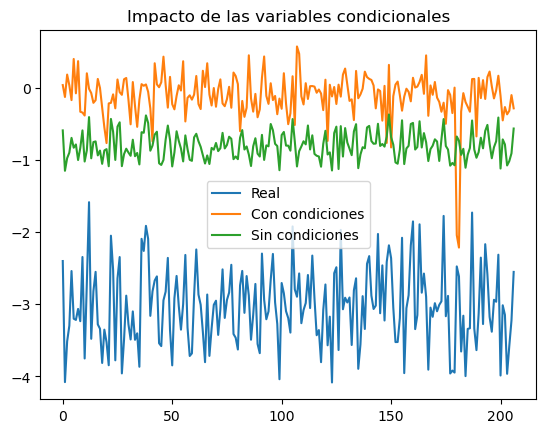

In [21]:
model.eval()
with torch.no_grad():
    x_sample = torch.tensor(x_test[100:101])
    c_normal = torch.tensor(c_test[100:101])
    c_fake = torch.zeros_like(c_normal)  # condiciones "neutrales"

    recon_normal = model(x_sample, c_normal)[0]
    recon_fake = model(x_sample, c_fake)[0]

    plt.plot(x_sample.numpy().flatten(), label="Real")
    plt.plot(recon_normal.numpy().flatten(), label="Con condiciones")
    plt.plot(recon_fake.numpy().flatten(), label="Sin condiciones")
    plt.legend()
    plt.title("Impacto de las variables condicionales")
    plt.show()


In [22]:
# import matplotlib.pyplot as plt

# plt.hist(reconstruction_errors, bins=50)
# plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
# plt.title("Distribución del error de reconstrucción")
# plt.xlabel("Error")
# plt.ylabel("Frecuencia")
# plt.legend()
# plt.show()


In [23]:
# plt.plot(reconstruction_errors, label='Error de reconstrucción')
# plt.axhline(threshold, color='red', linestyle='--', label='Umbral (95%)')
# plt.scatter(np.where(anomalies)[0], np.array(reconstruction_errors)[anomalies], color='orange', label='Anomalías')
# plt.legend()
# plt.title("Errores de reconstrucción y anomalías detectadas")
# plt.xlabel("Índice de muestra")
# plt.ylabel("MSE")
# plt.show()


#### Sliding Windows

Sliding windows allow us to structure the time series data as sequences of fixed length, suitable for feeding into our VAE model.

The window size of 12 means each sample contains 12 consecutive timesteps (i.e., one hour of data).


In [24]:
# def create_sliding_windows(data, window_size):
#     X = []
#     # for i in range(len(data) - window_size):
#     #     X.append(data[i:i+window_size])
#     i: int = 0
#     while i < 34272:
#         X.append(data[i:i+window_size])
#         i= i + 12
#     return np.array(X)

# window_size = 12  # 12 pasos = 1 hora
# X = create_sliding_windows(data_normalized, window_size)  # shape: (34260, 12, 207)
# # 12 = rows
# # 34260 =  
# # 
# print(X.shape)


## CVAE + Long Short Term Memory (LSTM) reconstruction in latent space

A **LSTM** (Long Short-Term Memory) is a type of recurrent neural network designed to model sequences and capture long-term dependencies through gated mechanisms that control information flow over time.

The **CVAE + LSTM** model extends the CVAE by introducing an LSTM that operates in the latent space. The CVAE encodes each timestep of a traffic speed sequence into an embedding; the LSTM then models the temporal evolution of these embeddings, predicting the last window_size-1 embeddings using the first window_size -1 ones. Only the **last predicted embedding** is decoded, summarizing the full sequence for reconstruction.

**Trainings** of CVAE and LSTM are kept separate: this improves stability and modularity:
* **Decoupled objectives**: The CVAE learns to encode/reconstruct, while the LSTM models temporal dynamics. Joint training can lead to conflicting gradients and unstable convergence.
* **Better control**: The encoder can be validated independently for embedding quality before feeding sequences to the LSTM.
* **Modularity**: Once trained, components can be reused or replaced independently (e.g., testing different sequence models on the same embeddings).
* **Simpler debugging**: Isolating errors or performance issues is easier when training in stages.

End-to-end training could be explored later for fine-tuning, once both parts perform well individually {????????????????}

> **Why use LSTM inside a CVAE for anomaly detection on traffic speed data?**
> VAE works out for indipendent input data, while time series are characterized by innate sequential dependencies. The inception of a LSTM modul inside the original CVAE allows to account for these dependencies.

### Main Components

* **Encoder (`x`)**: Maps each timestep of input to a latent embedding.
* **Condition (`c`)**: Provides context (e.g., time, day type) to guide encoding and decoding.
* **LSTM**: Models the sequence of embeddings and predicts the next (last) embedding.
* **Decoder**: Reconstructs the final output from the last predicted embedding.

### In the next sections

First, we present the LSTM model definition, the preprocessing of CVAE-embeddings as LSTM input data,  and the LSTM training over the train data set. The we move to the CVAE_LSTM model definition and we assess its performance over the test dataset {by?????}. Reconstructed time series are plotted. 
Finally, the score function matrix is build, where scores for each sensor are provided over a customizable window_size. According to a percentile threshold, sensors are flagged as anomalous or not over precise lenght windows.

### LSTM model training

#### 1. LSTM model definition

In [25]:
# --- LSTM ---
class LSTM_Predictor(nn.Module):
    """
    LSTM-based predictor for sequences of latent embeddings.

    Args:
        embedding_dim (int): Dimensionality of each embedding in the sequence.
        hidden_dim (int): Number of hidden units in the LSTM.
        num_layers (int): Number of stacked LSTM layers.
        dropout_prob (float): Dropout probability (applied if num_layers > 1). For regularization.

    Methods:
        forward(x): Returns predicted embedding sequence.
        compute_loss(predicted_sequence, target_last_embedding): Computes MSE loss on last predicted embedding.
    """
    def __init__(self, embedding_dim, hidden_dim, num_layers=1, dropout_prob=0.1):
        super(LSTM_Predictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM processes input sequences of embeddings
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True, # input output LSTM: (batch, seq, feature).
            dropout=dropout_prob if num_layers > 1 else 0
        )
        # Linear layer maps LSTM outputs back to embedding space
        self.fc = nn.Linear(hidden_dim, embedding_dim)

        # MSE loss for comparing predicted and true embeddings
        self.criterion = nn.MSELoss() #draft3 +

    def forward(self, x):
        """
        Forward pass through LSTM and linear layer.

        Args:
            x (Tensor): Input of shape (batch_size, seq_len, embedding_dim)

        Returns:
            predictions (Tensor): Predicted embeddings, shape (batch_size, seq_len, embedding_dim)
        """
        lstm_out, _ = self.lstm(x) # LSTM output: (batch, seq_len, hidden_dim)
        predictions = self.fc(lstm_out) # Map to embedding_dim
        return predictions
    
    # loss : draft3 +
    def compute_loss(self, predicted_sequence, target_last_embedding):
        """
        Compute MSE loss between the last predicted embedding and the true last embedding.

        Args:
            predicted_sequence (Tensor): Output from forward(), shape (batch_size, seq_len, embedding_dim)
            target_last_embedding (Tensor): True last embedding, shape (batch_size, embedding_dim)

        Returns:
            loss (Tensor): Scalar MSE loss
        """
        predicted_last = predicted_sequence[:, -1, :] #Last time step prediction
        loss = self.criterion(predicted_last, target_last_embedding)
        return loss

#### 2. From raw to LSTM input data
...

In [26]:
# Extract all latent embeddings (mu) from the trained VAE for both train and test sets
def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x_batch, c_batch in data_loader:
            x_batch, c_batch = x_batch.to(device), c_batch.to(device) 
            mu, _ = model.encode(x_batch, c_batch)
            embeddings.append(mu.cpu())
    return torch.cat(embeddings, dim=0) 

# Redefine train_loader with shuffle=False to preserve temporal order for sequential embeddings
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False) 
print(len(train_loader))

# Extract embeddings for train and test sets
embeddings_train = get_embeddings(model, train_loader, device)
embeddings_test = get_embeddings(model, test_loader, device)
print("Embeddings train:", embeddings_train.shape)
print("Embeddings test:", embeddings_test.shape)

215
Embeddings train: torch.Size([27417, 16])
Embeddings test: torch.Size([6855, 16])


In [27]:
# Create sliding windows from embeddings for LSTM input/target
def create_sliding_windows(embeddings, window_size=12):
    """
    Given a tensor of shape [N, D], returns a tensor of shape [num_windows, window_size, D],
    where each window contains 'window_size' consecutive embeddings.
    Windows are created with stride 1 (fully overlapping).
    """
    windows = []
    # Generate all possible windows of length 'window_size'
    for i in range(0, len(embeddings) - window_size + 1):
        windows.append(embeddings[i:i + window_size])
    return torch.stack(windows)

window_size = 12  # 12 steps = 1 hour of data per window
train_windows = create_sliding_windows(embeddings_train, window_size)
test_windows = create_sliding_windows(embeddings_test, window_size)

print(train_windows.shape)  # [num_train_windows, 12, latent_dim]
print(test_windows.shape)   # [num_test_windows, 12, latent_dim]

torch.Size([27406, 12, 16])
torch.Size([6844, 12, 16])


In [28]:
from torch.utils.data import TensorDataset

# Prepare input and target tensors for LSTM training
# Input: first 11 embeddings in each window (e_1, ..., e_11)
X_train_lstm = train_windows[:, :11, :]
# Target: the last embedding in each window (e_12), used for loss computation
Y_train_lstm_for_loss = train_windows[:, -1, :]

X_test_lstm = test_windows[:, :11, :]
Y_test_lstm_for_loss = test_windows[:, -1, :]

print(f"Shape of X_train_lstm: {X_train_lstm.shape}")
print(f"Shape of Y_train_lstm_for_loss: {Y_train_lstm_for_loss.shape}")

# Create DataLoaders for LSTM training and evaluation
batch_size_lstm = 64  # You can adjust this batch size
train_dataset_lstm = TensorDataset(X_train_lstm, Y_train_lstm_for_loss)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size_lstm, shuffle=False) # COULD WE USE SHUFFLE? WOULD IT MEAN SHUFFLING TEMPORAL WINDOWS (KEEPING THE SEQUENCE ORDER WITHIN)?
test_dataset_lstm = TensorDataset(X_test_lstm, Y_test_lstm_for_loss)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)

Shape of X_train_lstm: torch.Size([27406, 11, 16])
Shape of Y_train_lstm_for_loss: torch.Size([27406, 16])


#### 3. LSTM training

In [29]:
# LSTM training
embedding_dim = X_train_lstm.shape[2]

# Tune the following as needed 
hidden_dim_lstm = 64    # Esempio, da ottimizzare
num_layers_lstm = 2     
learning_rate_lstm = 0.001 
num_epochs_lstm = 50    
#dropout_prob_lstm  = 0.2 

# Initialize LSTM model and optimizer
lstm_model = LSTM_Predictor(embedding_dim, hidden_dim_lstm, num_layers_lstm, dropout_prob=0.2).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate_lstm)

for epoch in range(num_epochs_lstm):
    lstm_model.train()  
    epoch_loss = 0.0
    for batch_X, batch_Y_target_last in train_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)
        optimizer_lstm.zero_grad()
        predicted_sequence = lstm_model(batch_X) # Forward pass: predict the sequence of embeddings
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader_lstm)
    print(f"Epoch [{epoch+1}/{num_epochs_lstm}], LSTM Loss: {avg_epoch_loss:.4f}")

Epoch [1/50], LSTM Loss: 0.0065
Epoch [2/50], LSTM Loss: 0.0033
Epoch [3/50], LSTM Loss: 0.0025
Epoch [4/50], LSTM Loss: 0.0021
Epoch [5/50], LSTM Loss: 0.0020
Epoch [6/50], LSTM Loss: 0.0019
Epoch [7/50], LSTM Loss: 0.0019
Epoch [8/50], LSTM Loss: 0.0019
Epoch [9/50], LSTM Loss: 0.0019
Epoch [10/50], LSTM Loss: 0.0019
Epoch [11/50], LSTM Loss: 0.0019
Epoch [12/50], LSTM Loss: 0.0019
Epoch [13/50], LSTM Loss: 0.0019
Epoch [14/50], LSTM Loss: 0.0019
Epoch [15/50], LSTM Loss: 0.0019
Epoch [16/50], LSTM Loss: 0.0019
Epoch [17/50], LSTM Loss: 0.0019
Epoch [18/50], LSTM Loss: 0.0019
Epoch [19/50], LSTM Loss: 0.0019
Epoch [20/50], LSTM Loss: 0.0019
Epoch [21/50], LSTM Loss: 0.0019
Epoch [22/50], LSTM Loss: 0.0019
Epoch [23/50], LSTM Loss: 0.0019
Epoch [24/50], LSTM Loss: 0.0019
Epoch [25/50], LSTM Loss: 0.0019
Epoch [26/50], LSTM Loss: 0.0019
Epoch [27/50], LSTM Loss: 0.0019
Epoch [28/50], LSTM Loss: 0.0019
Epoch [29/50], LSTM Loss: 0.0019
Epoch [30/50], LSTM Loss: 0.0019
Epoch [31/50], LSTM

#### 4. LSTM output embeddings over train set, and plots

In [30]:
from collections import deque

# Evaluate LSTM on test embeddings and collect predictions
lstm_out_embeddings = []

lstm_model.eval()  
with torch.no_grad():
    test_losses = []
    for batch_X, batch_Y_target_last in test_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)
        predicted_sequence = lstm_model(batch_X)
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        test_losses.append(loss.item())
        lstm_out_embeddings.append(predicted_sequence[:, -1, :].cpu())
    
# Compute average loss over the test set
avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss LSTM: {avg_test_loss:.4f}")

# Concatenate all predictions into a single tensor
lstm_out_embeddings = torch.cat(lstm_out_embeddings, dim=0) 
print("Shape of LSTM predictions:", lstm_out_embeddings.shape)  # [num_test_windows, embedding_dim]
print(embeddings_test)

Test Loss LSTM: 0.0017
Shape of LSTM predictions: torch.Size([6844, 16])
tensor([[-1.3744e-03,  4.9498e-04, -1.0072e-02,  ..., -2.1360e-02,
          3.4023e-01, -1.6148e-02],
        [-1.3516e-03,  2.0424e-04, -8.0380e-03,  ..., -1.7514e-02,
          2.8506e-01, -1.2991e-02],
        [-1.1687e-03,  1.3518e-03, -9.4994e-03,  ..., -1.9614e-02,
          3.2623e-01, -1.4487e-02],
        ...,
        [-1.3585e-03,  6.9695e-06, -7.1958e-03,  ..., -1.5976e-02,
          2.6210e-01, -1.1748e-02],
        [-1.3454e-03,  9.1827e-06, -6.8920e-03,  ..., -1.5370e-02,
          2.5393e-01, -1.1238e-02],
        [-1.3529e-03,  7.9035e-06, -7.0676e-03,  ..., -1.5720e-02,
          2.5865e-01, -1.1533e-02]])


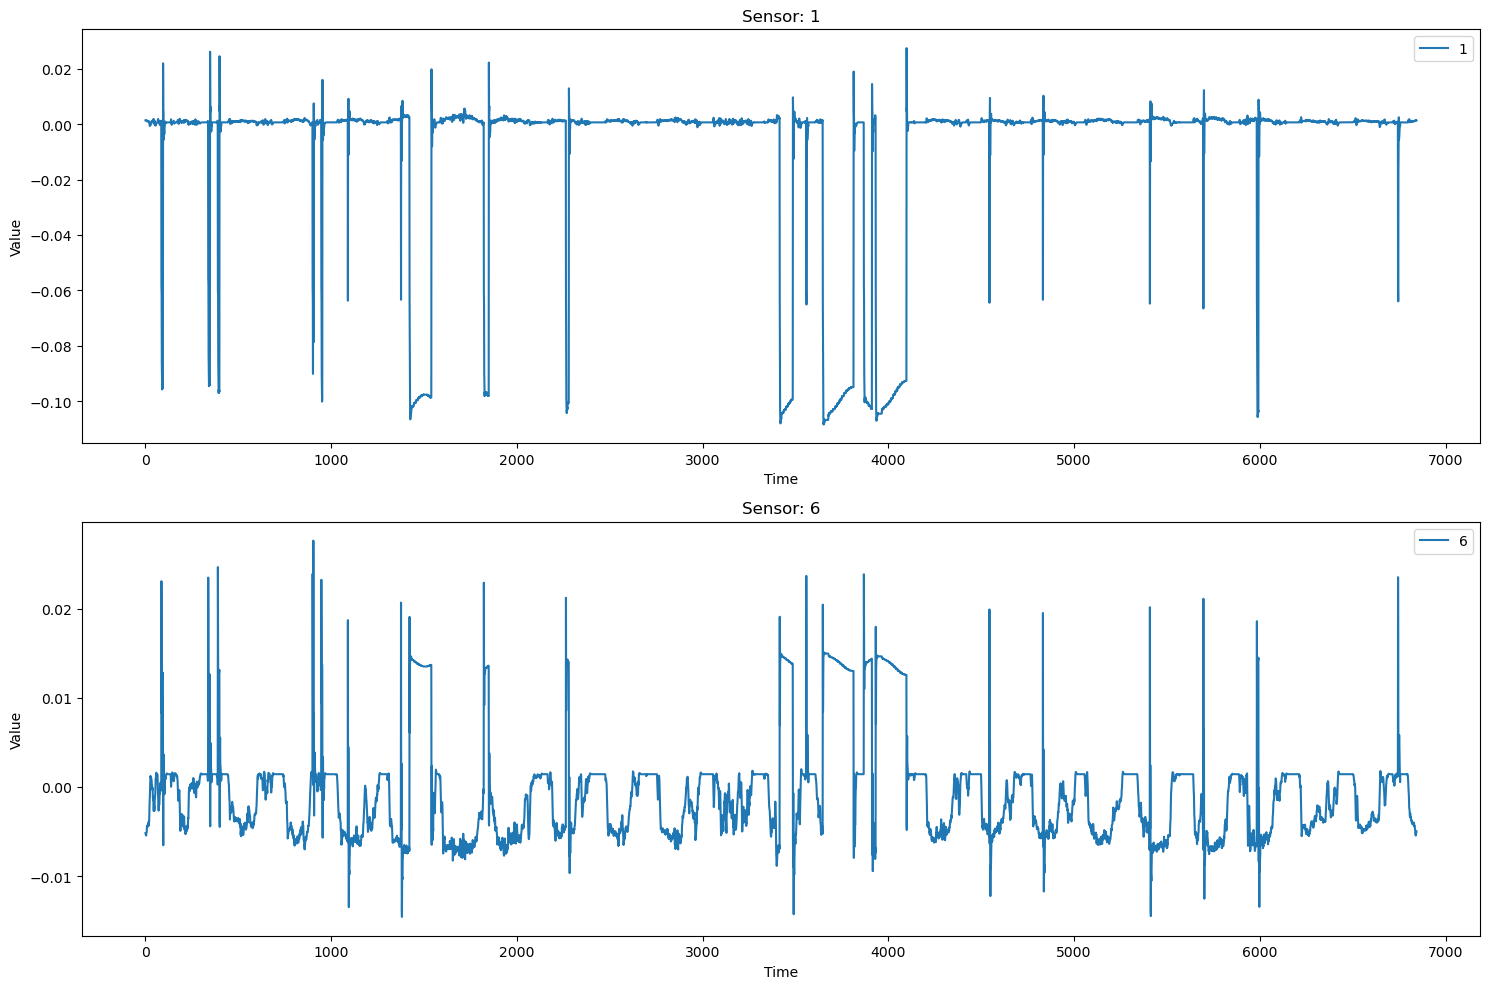

In [31]:
# plot of embedded time series for 3 sensors (test set)
specific_sensors = ["716339", "765164", "716328"]
lstm_out_embeddings_pd = pd.DataFrame(lstm_out_embeddings.numpy()) 
np.random.seed(0)  
embed_time_series = plot_random_sensors(lstm_out_embeddings_pd, num_sensors=2)

### CVAE_LSTM model, outputs and visualisation
#### 1. CVAE_LSTM model and training over train dataset

In [32]:
# --- CVAE + LSTM ---
class CVAE_LSTM(nn.Module):
    """
    This model extends the standard CVAE by integrating a temporal LSTM module in the latent space.
    During evaluation, the LSTM predicts the next latent embedding from a sequence of previous embeddings, 
    allowing the decoder to reconstruct x based on temporally-aware latent dynamics.
    """
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        super(CVAE_LSTM, self).__init__()

        # Encoder: concatenates x and c, then passes through two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # Latent space: outputs mean (mu) and log-variance (logvar) for z
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder: reconstructs x from latent z and condition c
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output matches original x dimension
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c, lstm_model=None, mu_queue=None, window_size=12): 
        """
        Forward pass for CVAE_LSTM:
        1) Encode (x, c) to get mu and logvar.
        2) Optionally, in eval mode, use LSTM to predict mu from a sequence of previous mus.
        3) Sample z using the reparameterization trick.
        4) Decode (z, c) to reconstruct x.

        Args:
            x: Input data
            c: Conditional features
            lstm_model: Trained LSTM model for temporal prediction (optional, used in eval)
            mu_queue: Sequence buffer for previous mus (optional, used in eval)
            window_size: Length of the mu sequence for LSTM (default: 12)

        Returns:
            x_recon: Reconstructed input
            mu: Mean of latent distribution
            logvar: Log-variance of latent distribution
        """
        # 1) Encode input and condition to latent parameters
        mu, logvar = self.encode(x, c)

        # 2) In evaluation mode, optionally use LSTM to predict mu from previous mus
        if (not self.training) and (lstm_model is not None) and (mu_queue is not None):   #only if CVAE is in eval mode and lstm_model and mu_queue are provided
            # debugging:
            print("CVAE in eval mode, applying LSTM to mu sequence")
            # Append current mu to the queue 
            mu_queue.append(mu)
            # mu_queue.append(mu.detach()) anzichè quello sopra
            if len(mu_queue) > window_size:
                mu_queue.pop(0)
                # mu_queue.popleft() anzichè quello sopra
            # If enough mus in queue, use LSTM to predict next mu
            if len(mu_queue) == window_size:
                mu_seq = torch.stack(list(mu_queue), dim=1)  # shape: (batch, window_size, latent_dim)
                lstm_model.eval()  # LSTM in eval mode
                with torch.no_grad():
                    lstm_out, _ = lstm_model(mu_seq)
                    mu = lstm_out[:, -1, :] # Use last LSTM output as predicted mu

        # 2) Sample z using reparameterization
        z = self.reparameterize(mu, logvar)
        
        # 3) Decode the sampled z (with c) → reconstruction
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model_cvae_lstm = CVAE_LSTM(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model_cvae_lstm(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 1.2043 | Recon: 1.0137 | KL: 0.1905
Epoch 2/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 3/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 4/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 5/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 6/50 - Loss: 1.2041 | Recon: 1.0136 | KL: 0.1905
Epoch 7/50 - Loss: 1.2041 | Recon: 1.0136 | KL: 0.1905
Epoch 8/50 - Loss: 1.2041 | Recon: 1.0136 | KL: 0.1905
Epoch 9/50 - Loss: 1.2042 | Recon: 1.0137 | KL: 0.1905
Epoch 10/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 11/50 - Loss: 1.2041 | Recon: 1.0136 | KL: 0.1905
Epoch 12/50 - Loss: 1.2041 | Recon: 1.0136 | KL: 0.1905
Epoch 13/50 - Loss: 1.2042 | Recon: 1.0137 | KL: 0.1905
Epoch 14/50 - Loss: 1.2042 | Recon: 1.0136 | KL: 0.1905
Epoch 15/50 - Loss: 1.2043 | Recon: 1.0138 | KL: 0.1905
Epoch 16/50 - Loss: 1.2042 | Recon: 1.0137 | KL: 0.1905
Epoch 17/50 - Loss: 1.2042 | Recon: 1.0137 | KL: 0.1905
Epoch 18/50 - Loss: 1.2042 | Recon: 1.0137 | KL: 0.1905
E

#### 2. CVAE_LSTM outputs on test set, and plots

In [34]:
# Evaluate CVAE_LSTM model on the test set using LSTM-driven latent dynamics.

"""
For each batch, maintain a queue of previous latent mus for each sample in the batch.
The queue is updated outside the model's forward() to ensure correct temporal alignment.
If the batch size changes (e.g., last batch), reinitialize the queues accordingly.
"""

window_size = 12
batch_size = test_loader.batch_size
mu_queues = [deque(maxlen=window_size) for _ in range(batch_size)] # One queue per sample in the batch
vae_lstm_recon = []
vae_lstm_originals = []

model_cvae_lstm.eval()
with torch.no_grad():
    for x_batch, c_batch in test_loader:
        # If batch size changes (e.g., last batch), reinitialize mu_queues
        if len(x_batch) != len(mu_queues):
            mu_queues = [deque(maxlen=window_size) for _ in range(len(x_batch))]
        # Forward pass: use LSTM to predict temporally-aware latent embedding
        x_recon, mu, logvar = model_cvae_lstm(
            x_batch, c_batch, 
            lstm_model=lstm_model, 
            mu_queue=mu_queues, 
            window_size=window_size
            )
        # Update mu_queues here(not inside the model's forward)
        vae_lstm_recon.append(x_recon.cpu())
        vae_lstm_originals.append(x_batch.cpu())

vae_lstm_recon_all = torch.cat(vae_lstm_recon, dim=0)     # [Nw_test, 207]
vae_lstm_originals = torch.cat(vae_lstm_originals, dim=0) # [Nw_test, 207]

CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu sequence
CVAE in eval mode, applying LSTM to mu s

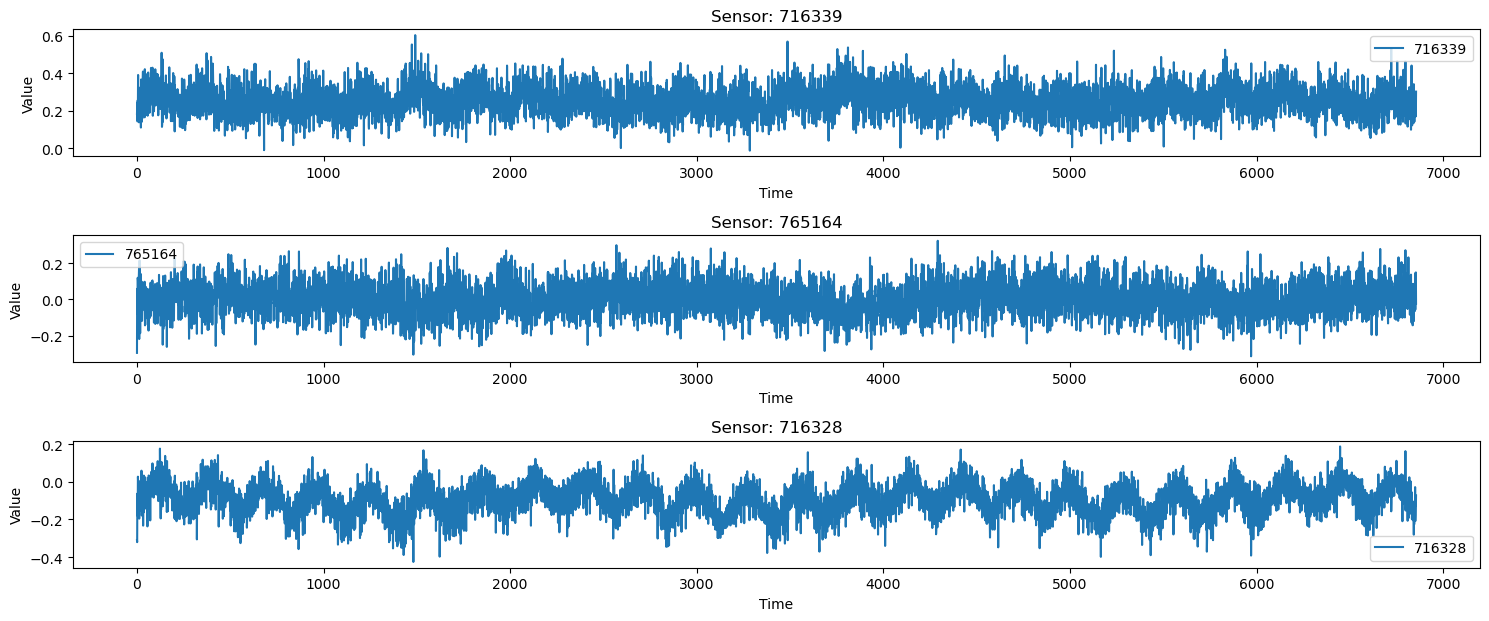

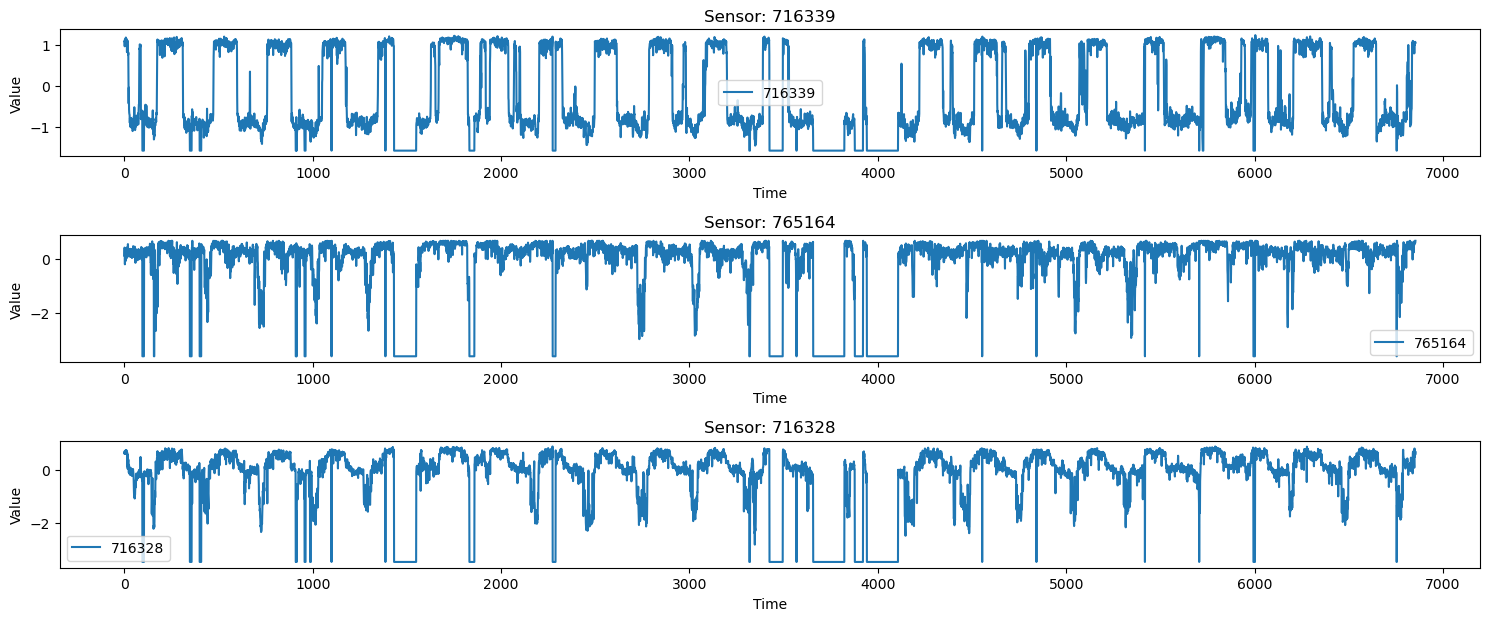

In [35]:
# plot of reconstructed time series for 3 sensors against the original ones of the same sensors (test set)
specific_sensors = ["716339", "765164", "716328"]
vae_lstm_recon_all_ = pd.DataFrame(vae_lstm_recon_all.numpy(), columns=df.columns) 
recon_time_series = plot_random_sensors(vae_lstm_recon_all_, num_sensors=5, sens=specific_sensors)

vae_lstm_originals_ = pd.DataFrame(vae_lstm_originals.numpy(), columns=df.columns) 
orig_time_series = plot_random_sensors(vae_lstm_originals_, num_sensors=5, sens=specific_sensors)

### SCORE FUNCTION 

We use the score function to compute the MSE between reconstruction and real data for each sensor and over defined time windows. This allows us to identify anomalous sensors when the error exceeds a percentile threshold, even over prolonged periods. In the future, it would be interesting to explore a composite score that considers both the magnitude of the anomaly and the number of anomalous sensors per window, for a more robust detection.

>$$
\text{Score}_{t \in W,s} = \sum_{t} \left(x^{\text{recon}}_{t,s} - x^{\text{orig}}_{t,s} \right)^2
$$

In [36]:
# MSE as a score function to spot anomalies, mse per sensor and over window of lenght windth_size

import torch.nn.functional as F

def score_function(x_recon, x_orig, window_size=12, percentile=99.5, index=None):
    """
    Compute the per-sensor MSE between reconstructed and original data, and a rolling mean over a window.
    Returns:
        mse_matrix: DataFrame of raw MSE values (samples x sensors)
        mse_windows: DataFrame of rolling mean MSE (windowed)
        thresholds: Array of per-sensor thresholds (percentile over all MSEs)
        thresholds_windows: Array of per-sensor thresholds (percentile over windowed MSEs)
    """
    # Ensure x_recon and x_orig have the same number of samples
    dif = x_recon.shape[0] - x_orig.shape[0]
    if dif > 0:
        x_recon = x_recon[:x_orig.shape[0]] 
    elif dif < 0:
        x_orig = x_orig[-x_recon.shape[0]:]
        
    # Compute per-sample, per-sensor MSE
    mse_matrix = (x_recon - x_orig) ** 2  
    mse_matrix = pd.DataFrame(mse_matrix, index=x_orig.index, columns=x_orig.columns)

    # Compute rolling mean MSE over the specified window size 
    mse_windows = mse_matrix.rolling(window=window_size, min_periods=window_size).mean() 

    # Compute anomaly thresholds as the given percentile for each sensor (over a window)
    thresholds = np.percentile(mse_matrix.values, percentile, axis=0) 
    thresholds_windows = np.percentile(mse_windows.values, percentile, axis=0) 

    return mse_matrix , mse_windows , thresholds, thresholds_windows


# Prepare indexes and columns for DataFrames
df_time_train, df_time_test = train_test_split(df_time, test_size=0.2, shuffle=False)
index = df_time_test.index  # Index for test set
index_lstm_decoded = df_time_test.index  # Index for windowed output .....before was index_lstm_decoded = df_time_test.index[window_size-1:] CHECK
columns = df.columns

# Convert decoded LSTM outputs and test data to DataFrames with correct indices
vae_lstm_recon_all_pd = pd.DataFrame(vae_lstm_recon_all, columns=columns, index=index_lstm_decoded) 
vae_lstm_originals_pd = pd.DataFrame(vae_lstm_originals, columns=columns, index=index)  

# Compute MSE matrices and thresholds
mse_matrix, mse_windows, thresh, thresh_windows = score_function(vae_lstm_recon_all_pd, vae_lstm_originals_pd, window_size=1, percentile=99.5)
print(mse_matrix.head())      # Show first rows of raw MSE matrix
print(mse_windows.head())     # Show first rows of rolling mean MSE matrix
print(thresh)                 # Print per-sensor thresholds (raw)
print(thresh_windows)         # Print per-sensor thresholds (windowed)

                       773869    767541    767542    717447    717446  \
2012-06-04 04:45:00  0.405708  0.129958  0.520937  0.326384  0.723819   
2012-06-04 04:50:00  0.503369  0.054300  0.374172  0.714315  0.879328   
2012-06-04 04:55:00  0.154905  0.357403  0.000197  0.689206  0.486847   
2012-06-04 05:00:00  0.247371  0.243168  0.244704  0.343220  0.636523   
2012-06-04 05:05:00  0.238349  0.076031  0.055581  0.311375  0.916723   

                       717445    773062    767620    737529    717816  ...  \
2012-06-04 04:45:00  0.218886  0.034546  0.189995  0.469716  0.651130  ...   
2012-06-04 04:50:00  0.001619  0.232202  0.007757  0.542486  0.739713  ...   
2012-06-04 04:55:00  0.019446  0.206572  0.009295  0.173503  0.494505  ...   
2012-06-04 05:00:00  0.003667  0.024980  0.000869  0.489710  0.607332  ...   
2012-06-04 05:05:00  0.009647  0.528608  0.013612  0.048839  0.442077  ...   

                       772167    769372        774204    769806    717590  \
2012-06-04 04:4